In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree.export import export_graphviz
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [2]:
data=pd.read_csv('train.csv')


data=data.drop('overall_time_mean_na',1)
data=data.drop('overall_time_min_na',1)
data=data.drop('overall_time_max_na',1)



features=pd.read_csv('feature_rank.csv')

cols=features['features'].tolist()

cols=cols[:70]

cols.append('label')

data=data[cols]

#data=data[data.columns.drop(list(data.filter(regex='log')))]

In [3]:
data_test=pd.read_csv('test.csv')


data_test=data_test.drop('overall_time_mean_na',1)
data_test=data_test.drop('overall_time_min_na',1)
data_test=data_test.drop('overall_time_max_na',1)



features=pd.read_csv('feature_rank.csv')

cols=features['features'].tolist()

cols=cols[:70]

cols.append('label')

data_test=data_test[cols]

#data_test=data_test[data_test.columns.drop(list(data_test.filter(regex='log')))]

In [4]:
X_train_original=data.drop(['label'],axis=1)

y_train_original = data['label']




In [5]:
X_test_original=data_test.drop(['label'],axis=1)

y_test_original=data_test['label']

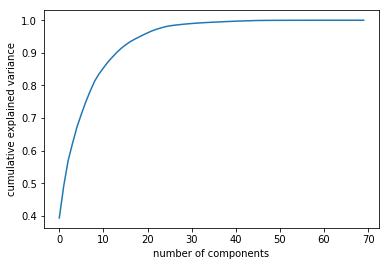

In [6]:
# Standardizing the features
x = StandardScaler().fit_transform(X_train_original)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 

#Explained variance
pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

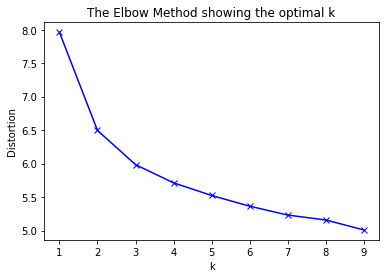

In [7]:
pca = PCA(n_components=15)
pca_train=pca.fit(x)

pca_train_features=pca_train.transform(x)

np.asmatrix(pca_train_features)[:,14]

for i in range(0,15):
    X_train_original['pca'+str(i)]=np.asmatrix(pca_train_features)[:,i]


pca_test_features=pca_train.transform(StandardScaler().fit_transform(X_test_original))

for i in range(0,15):
    X_test_original['pca'+str(i)]=np.asmatrix(pca_test_features)[:,i]



from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy.spatial.distance import cdist

# create new plot and data
plt.plot()
sc = StandardScaler()


# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(x)
    kmeanModel.fit(x)
    distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

kmeans = KMeans(n_clusters=4, random_state=0).fit(x)

X_train_original['cluster']=kmeans.labels_

X_test_original['cluster']=kmeans.predict(StandardScaler().fit_transform(X_test_original[X_test_original.columns.drop(list(X_test_original.filter(regex='pca')))]))

In [8]:

dataX={'all features':X_train_original}

In [ ]:


model_coe={}
for XX in dataX.keys():
    print('**********')
    print(XX)
    
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    sss.get_n_splits(dataX[XX], y_train_original)  
    i=0
    ptest={}
    ptrain={}
    ptest_scal={}
    ptrain_scal={}
    
  

    for c in [1,0.1,10]:
        ptest[c]=0
        ptrain[c]=0
        ptest_scal[c]=0
        ptrain_scal[c]=0
        
        
        

    for train_index, test_index in sss.split(dataX[XX], y_train_original):
        i+=1
        print(i)

        X_train, X_test = dataX[XX].iloc[train_index], dataX[XX].iloc[test_index]
        y_train, y_test = y_train_original[train_index], y_train_original[test_index]
            
        sm = SMOTE(random_state=12, sampling_strategy = 1.0)
        X_train, y_train = sm.fit_sample(X_train, y_train)
        
        ###scale
        sc = StandardScaler()
            
        X_train2= sc.fit_transform(X_train)
        X_test2= sc.transform (X_test)
        
  
        for c in [1,0.1,10]:

            print('C -------',c)


            clf = LogisticRegression(penalty='l1', C=c)
            clf.fit(X_train, y_train)
            
            #clf_predict_test=clf.predict(X_test)

            #clf_predict_train=clf.predict(X_train)
            
            
            print(clf.classes_)

            
            fpr, tpr, threshold = metrics.roc_curve(y_train, clf.predict_proba(X_train)[:,1])
            roc_auc = metrics.auc(fpr, tpr)
            ptrain[c]+=roc_auc/5

            fpr, tpr, threshold = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
            roc_auc = metrics.auc(fpr, tpr)
            ptest[c]+=roc_auc/5
            
          
            
#             coef_dict = {}
#             for coef, feat in zip(clf.coef_[0],dataX[XX].columns.tolist()):
#                 coef_dict[feat] = coef
            
#             model_coe[XX+'_'+str(c)+'_noscale']=coef_dict

            ###scale
            

            clf = LogisticRegression(penalty='l1', C=c)
            clf.fit(X_train2, y_train)
            #clf_predict_test=clf.predict(X_test2)

            #clf_predict_train=clf.predict(X_train2)


            fpr, tpr, threshold = metrics.roc_curve(y_train, clf.predict_proba(X_train2)[:,1])
            roc_auc = metrics.auc(fpr, tpr)
            ptrain_scal[c]+=roc_auc/5

            fpr, tpr, threshold = metrics.roc_curve(y_test, clf.predict_proba(X_test2)[:,1])
            roc_auc = metrics.auc(fpr, tpr)
            ptest_scal[c]+=roc_auc/5

            
            

      
            
            
#             coef_dict = {}
#             for coef, feat in zip(clf.coef_[0],dataX[XX].columns.tolist()):
#                 coef_dict[feat] = coef
            
#             model_coe[XX+'_'+str(c)+'_scale']=coef_dict
        for c in [1,0.1,10]:
            print('train',ptrain[c])
            print('test',ptest[c])
            print('train_scale',ptrain_scal[c])
            print('test_scale',ptest_scal[c])



**********
all features
1
C ------- 1
[0. 1.]
C ------- 0.1
[0. 1.]
C ------- 10
[0. 1.]
train 0.1767457601952527
test 0.17411590424056017
train_scale 0.17674380923964678
test_scale 0.1741177331519368
train 0.17672673453776802
test 0.17411820830583538
train_scale 0.17672099825664916
test_scale 0.17412769640760958
train 0.17674790301044332
test 0.174111666884351
train_scale 0.1767463512049791
test_scale 0.17411517494513037
2
C ------- 1
[0. 1.]
C ------- 0.1


In [ ]:
for c in [1,0.1,10]:
    print(c)
    print('train',ptrain[c])
    print('test',ptest[c])
    print('train_scale',ptrain_scal[c])
    print('test_scale',ptest_scal[c])

In [45]:

            
sm = SMOTE(random_state=12, sampling_strategy = 1.0)
X_train, y_train = sm.fit_sample(X_train_original, y_train_original)


clf = RandomForestClassifier(bootstrap= True,
                 max_depth=15,
                 max_features='auto',
                 n_estimators=2000,n_jobs=-1)
clf.fit(X_train, y_train)

testprob=clf.predict_proba(X_test_original)[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test_original, testprob)
roc_auc = metrics.auc(fpr, tpr)

In [46]:
roc_auc

0.8743127286929017

In [47]:
len(testprob)

38371

In [48]:
prob1=pd.DataFrame(columns=['random_forest'])

In [49]:
prob1['random_forest']=testprob

In [50]:
prob1.to_csv('random_forest.csv',index=False)

In [4]:

final_prob=0
model_coe={}
for XX in dataX.keys():
    print('**********')
    print(XX)
    
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    sss.get_n_splits(dataX[XX], y)  
    i=0
    ptest={}
    ptrain={}
    ptest_scal={}
    ptrain_scal={}
    
  

    for c in [1]:
        ptest[c]=0
        ptrain[c]=0
        ptest_scal[c]=0
        ptrain_scal[c]=0
        
        
        

    for train_index, test_index in sss.split(dataX[XX], y):
        i+=1
        print(i)

        X_train, X_test = dataX[XX].iloc[train_index], dataX[XX].iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
            
#         sm = SMOTE(random_state=12, sampling_strategy = 1.0)
#         X_train, y_train = sm.fit_sample(X_train, y_train)
        
        ###scale
        sc = StandardScaler()
            
        X_train2= sc.fit_transform(X_train)
        X_test2= sc.transform (X_test)
       
        for c in [1]:

            print('C -------',c)


            

            clf = LogisticRegression(penalty='l1', C=c)
            clf.fit(X_train, y_train)
            
            #clf_predict_test=clf.predict(X_test)

            #clf_predict_train=clf.predict(X_train)
            
            
            print(clf.classes_)

            
            fpr, tpr, threshold = metrics.roc_curve(y_train, clf.predict_proba(X_train)[:,1])
            roc_auc = metrics.auc(fpr, tpr)
            ptrain[c]+=roc_auc/5

            fpr, tpr, threshold = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
            roc_auc = metrics.auc(fpr, tpr)
            ptest[c]+=roc_auc/5
            
            final_prob+=clf.predict_proba(X_test)[:,1]/5
          
            
#             coef_dict = {}
#             for coef, feat in zip(clf.coef_[0],dataX[XX].columns.tolist()):
#                 coef_dict[feat] = coef
            
#             model_coe[XX+'_'+str(c)+'_noscale']=coef_dict

            ###scale
            

            clf = LogisticRegression(penalty='l1', C=c)
            clf.fit(X_train2, y_train)
            #clf_predict_test=clf.predict(X_test2)

            #clf_predict_train=clf.predict(X_train2)


            fpr, tpr, threshold = metrics.roc_curve(y_train, clf.predict_proba(X_train2)[:,1])
            roc_auc = metrics.auc(fpr, tpr)
            ptrain_scal[c]+=roc_auc/5

            fpr, tpr, threshold = metrics.roc_curve(y_test, clf.predict_proba(X_test2)[:,1])
            roc_auc = metrics.auc(fpr, tpr)
            ptest_scal[c]+=roc_auc/5
            
            
#             coef_dict = {}
#             for coef, feat in zip(clf.coef_[0],dataX[XX].columns.tolist()):
#                 coef_dict[feat] = coef
            
#             model_coe[XX+'_'+str(c)+'_scale']=coef_dict
    for c in [1]:
        print('train',ptrain[c])
        print('test',ptest[c])
        print('train_scale',ptrain_scal[c])
        print('test_scale',ptest_scal[c])





**********
all features
1
C ------- 1
[0. 1.]
2
C ------- 1
[0. 1.]
3
C ------- 1
[0. 1.]
4
C ------- 1
[0. 1.]
5
C ------- 1
[0. 1.]
train 0.8719822994643202
test 0.8731242892927047
train_scale 0.8719935621774341
test_scale 0.8731328321421865


In [5]:
prob=pd.DataFrame(columns=['lr_prob'])

prob['lr_prob']=final_prob

prob.to_csv('lr_prob.csv',index=False)